## BOPS
De acuerdo a las ventas promedio por semana y por tienda (o DMA) reportadas parece que la estrategia no está funcionando. Sin embargo, éstas no toman en cuenta si la estrategia funciona cuando existen tiendas cercanas a un DMA. Este factor podría ser crucial para un cliente cuando toma la decisión de usar el servicio BOPS.

Buscamos entonces el promedio semanal de ventas en DMAs con tiendas cercanas y lejanas; las comparamos.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn import linear_model

online_sales = pd.read_csv('datos/bops_online.csv',thousands=r',',usecols=range(7))
bm_sales = pd.read_csv('datos/bops_bm.csv',thousands=r',',usecols=range(7))

close_sales = online_sales[online_sales['close']==1]
far_sales = online_sales[online_sales['close']==0]

before_sales = ['Before BOPS']
after_sales = ['After BOPS']
before_sales.append(np.mean(close_sales[close_sales['after']==0].iloc[:,6])) #6 sales
before_sales.append(np.mean(far_sales[far_sales['after']==0].iloc[:,6]))
after_sales.append(np.mean(close_sales[close_sales['after']==1].iloc[:,6]))
after_sales.append(np.mean(far_sales[far_sales['after']==1].iloc[:,6]))
table_sales = []
table_sales.append(before_sales)
table_sales.append(after_sales)

print(tabulate(table_sales,headers=['','Close','Far'])) #Ventas online


               Close      Far
-----------  -------  -------
Before BOPS  13743.6  15659.2
After BOPS   11615.5  13771


Sin importar la cercanía a tiendas las ventas promedio disminuyeron después de aplicar la nueva estrategia.

Otro factor que no toma en cuenta el reporte inicial es la tendencia de las ventas. Es decir, es posible que las ventas furan disminuyendo desde antes de aplicar la estrategia y esta tendencia se pudo haber frenado después. Para comprobar esto podemos usar una proyectar las ventas sin BOPS y con BOPS y comparar las tendencias.

Primero obtenemos las ventas promedio en orden cronológico.

In [2]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
sc =SparkContext()
sqlContext = SQLContext(sc)

In [23]:
df_online = sqlContext.read.csv('datos/bops_online.csv', header=True, inferSchema= True)
df_bm = sqlContext.read.csv('datos/bops_bm.csv', header=True, inferSchema= True)
df_online.show()

+--------+----+-----+----+-----+-----+-----+
|id (DMA)|year|month|week|after|close|sales|
+--------+----+-----+----+-----+-----+-----+
|       1|2011|    4|  17|    0|    1|18564|
|       1|2011|    4|  18|    0|    1|30883|
|       1|2011|    5|  19|    0|    1|37425|
|       1|2011|    5|  20|    0|    1|32563|
|       1|2011|    5|  21|    0|    1|35773|
|       1|2011|    5|  22|    0|    1|33142|
|       1|2011|    5|  23|    0|    1|31752|
|       1|2011|    6|  24|    0|    1|44807|
|       1|2011|    6|  25|    0|    1|31873|
|       1|2011|    6|  26|    0|    1|31290|
|       1|2011|    6|  27|    0|    1|18165|
|       1|2011|    7|  28|    0|    1|24031|
|       1|2011|    7|  29|    0|    1|16518|
|       1|2011|    7|  30|    0|    1| 6845|
|       1|2011|    7|  31|    0|    1|11946|
|       1|2011|    8|  32|    0|    1|20217|
|       1|2011|    8|  33|    0|    1|19117|
|       1|2011|    8|  34|    0|    1|15089|
|       1|2011|    8|  35|    0|    1|11507|
|       1|

Podemos graficar las ventas de tiendas y online.

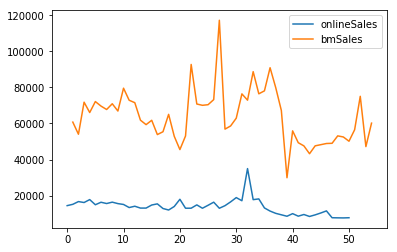

In [26]:
df_online.registerTempTable('online') #DMAs 169
df_bm.registerTempTable('bm') #Tiendas 210
series_online = sqlContext.sql('SELECT year, month, week, MEAN(sales) AS onlineSales FROM online GROUP BY year, month, week ORDER BY year, month, week')
series_bm = sqlContext.sql('SELECT year, month, week, MEAN(sales) AS bmSales FROM bm GROUP BY year, month, week ORDER BY year, month, week')
series_online.toPandas().loc[:,'onlineSales'].plot()
series_bm.toPandas().loc[:,'bmSales'].plot()
plt.legend()
plt.show()

Las ventas muestran picos en algunas epocas del año. Es difícil determinar si la estrategia nueva funciona con estos datos pues no hay una comparación directa entre las mismas épocas del año.

Obtenemos una proyección sencilla con regresión lineal. Primero para ventas online antes de BOPS.

Prendiente antes de BOPS:-80.0474587536164


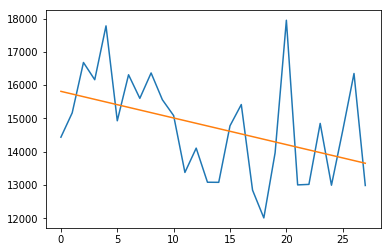

In [54]:
from sklearn import linear_model
b_online = series_online.toPandas().loc[:27,'onlineSales']
a_online = series_online.toPandas().loc[27:,'onlineSales']
b_bm = series_bm.toPandas().loc[:27,'bmSales']
a_bm = series_bm.toPandas().loc[27:,'bmSales']

reg = linear_model.LinearRegression()

reg.fit(np.asarray(list(range(28))).reshape(-1,1),b_online) #after row 28
b_pred=reg.predict(np.asarray(list(range(28))).reshape(-1,1))
m_online = reg.coef_[0]
i_online = reg.intercept_
print("Prendiente antes de BOPS:" +str(m_online))

plt.plot(np.asarray(list(range(28))).reshape(-1,1), b_online)
plt.plot(np.asarray(list(range(28))).reshape(-1,1), b_pred)
plt.show()

Después de BOPS.

Prendiente despues de BOPS:-542.1617225672877


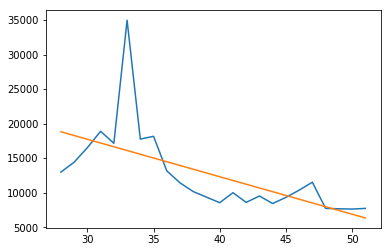

In [38]:
reg.fit(np.asarray(list(range(28,52))).reshape(-1,1),a_online)
a_pred=reg.predict(np.asarray(list(range(28,52))).reshape(-1,1))
print("Prendiente despues de BOPS:" +str(reg.coef_[0]))

plt.plot(np.asarray(list(range(28,52))).reshape(-1,1), a_online)
plt.plot(np.asarray(list(range(28,52))).reshape(-1,1), a_pred)
plt.show()

La tendencia a la baja empeora después de haber implementado la estrategia. Es posible que se deba a que la temporada más alta de ventas en el año ocurre justo al inicio de BOPS. Nuevamente necesitariamos más datos para tener una conclusión definitiva.

Hacemos lo mismo para las ventas en tienda.

Prendiente antes de BOPS:377.9208890452732


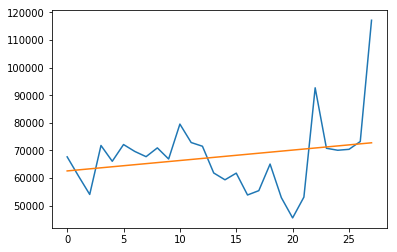

In [71]:
b_bm = b_bm.fillna(b_bm.mean())
reg.fit(np.asarray(list(range(28))).reshape(-1,1),b_bm)
b_pred=reg.predict(np.asarray(list(range(28))).reshape(-1,1))
m_bm = reg.coef_[0]
i_bm = reg.intercept_
print("Prendiente antes de BOPS:" +str(m_bm))

plt.plot(np.asarray(list(range(28))).reshape(-1,1), b_bm)
plt.plot(np.asarray(list(range(28))).reshape(-1,1), b_pred)
plt.show()

Prendiente despues de BOPS:-1171.1430233012748


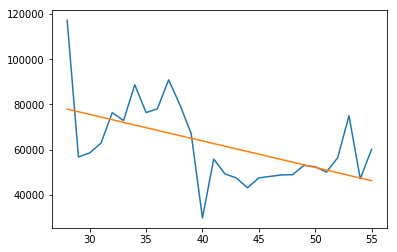

In [49]:
a_bm = a_bm.fillna(a_bm.mean())
reg.fit(np.asarray(list(range(28,56))).reshape(-1,1),a_bm)
a_pred=reg.predict(np.asarray(list(range(28,56))).reshape(-1,1))
print("Prendiente despues de BOPS:" +str(reg.coef_[0]))

plt.plot(np.asarray(list(range(28,56))).reshape(-1,1), a_bm)
plt.plot(np.asarray(list(range(28,56))).reshape(-1,1), a_pred)
plt.show()

La tendencia inicial era un aumento en las ventas y parece haber empeorado con BOPS. Nuevamente las distintas épocas del año parecen ser determinantes.

Finalmente, tratamos de estimar las ganancias o pérdidas tras implementar la estrategia. Se proyectan las ventas sin BOPS a los 6 meses que lleva en aplicación el programa usando la ecuación lineal encontrada.

In [68]:
pred_ventas_online = 0
pred_ventas_bm = 0
for i in range(28,52):
    pred_ventas_online += (m_online * i + i_online) * 169 #promedio estimado por numero de DMAS
for i in range(28,52):
    pred_ventas_bm += (m_bm * i + i_bm) * 210 #promedio estimado por numero de tiendas
ventas_online = sqlContext.sql('SELECT SUM(sales) FROM online').first()[0]
ventas_bm = sqlContext.sql('SELECT SUM(sales) FROM bm').first()[0]
estimadas = ['Estimated']
reales = ['Real']
dif = ['Change']
estimadas.append(pred_ventas_online)
estimadas.append(pred_ventas_bm)
reales.append(ventas_online)
reales.append(ventas_bm)
dif.append(pred_ventas_online - ventas_online)
dif.append(pred_ventas_bm - ventas_bm)
tabla_ventas = []
tabla_ventas.append(estimadas)
tabla_ventas.append(reales)
tabla_ventas.append(dif)
print(tabulate(tabla_ventas, headers=['','BM','Online']))
print('TOTAL : ' +str(dif[1]+dif[2]))

                     BM       Online
---------  ------------  -----------
Estimated   5.13146e+07  3.90457e+08
Real        1.47324e+08  2.89729e+08
Change     -9.6009e+07   1.00728e+08
TOTAL : 4718788.002189338


# Respuestas
1. ¿Deberían expandirse a Canadá?

Usando solo los datos del caso no recomendaría expandir la estrategia a Canadá. Recomendaría también obtener más datos antes de tomar una decisión definitiva para poder determinar adecuadamente la efectividad de la iniciativa.

2. ¿Cuántos   millones   de   dólares   se   ganaron   o   perdieron   a   partir   del   programa?   Explica   tu  razonamiento y metodología.

Se estimaron las ganancias sin BOPS usando la ecuación encontrada con regresión lineal. A pesar de ser un modelo sencillo, es difícil encontrar uno que prediga correctamente las ventas dado los pocos datos que se tienen.

Se comparó la estimación con las ventas reales tanto para tiendas como online. Interesantemente, parece haber habido ganancias en tiendas físicas despúes de iniciar el programa. En total se estiman pérdidas por 4.7 millones de dólares a partir del programa.